In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [3]:
# Load data
df = pd.read_csv('df_encoded.csv')

In [5]:
# Handle missing values
df['hours_level'] = df['hours_level'].fillna(df['hours_level'].mode()[0])

C:\Users\SMAGDY\AppData\Local\Temp\ipykernel_13832\3355357882.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette='coolwarm')


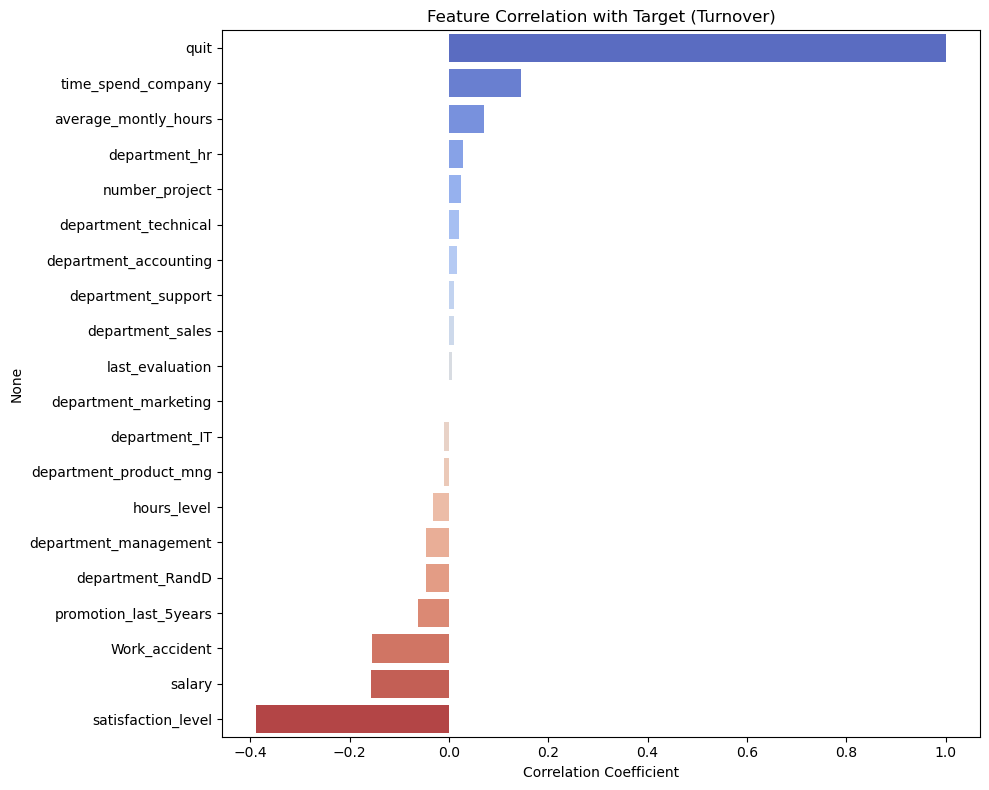

In [7]:
# Step 1: Feature importance analysis

# 1.1 Correlation with target
plt.figure(figsize=(10, 8))
corr_with_target = df.corr()['quit'].sort_values(ascending=False)
sns.barplot(x=corr_with_target.values, y=corr_with_target.index, palette='coolwarm')
plt.title('Feature Correlation with Target (Turnover)')
plt.xlabel('Correlation Coefficient')
plt.tight_layout()
plt.savefig('correlation_with_target.png', dpi=300)
plt.show()


In [9]:
# 1.2 Mutual Information
X = df.drop('quit', axis=1)
y = df['quit']

C:\Users\SMAGDY\AppData\Local\Temp\ipykernel_13832\2104933953.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='MI_Score', y='Feature', data=mi_df.head(15), palette='rocket')


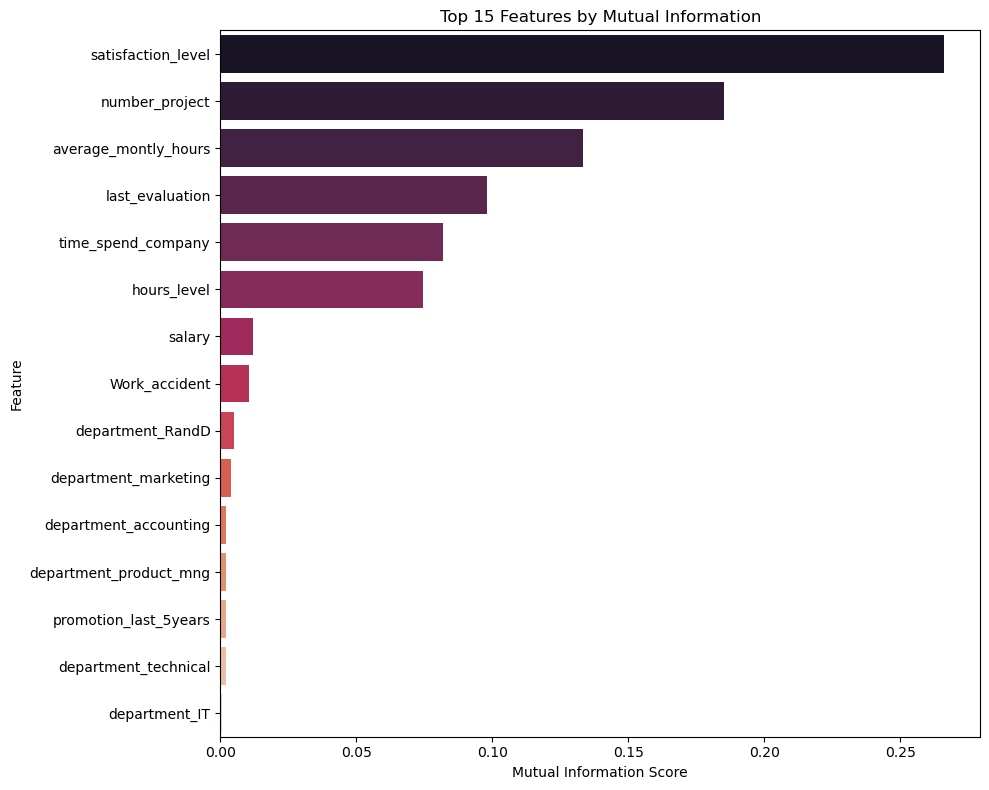

In [11]:
mi_scores = mutual_info_classif(X, y)
mi_df = pd.DataFrame({'Feature': X.columns, 'MI_Score': mi_scores})
mi_df = mi_df.sort_values('MI_Score', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='MI_Score', y='Feature', data=mi_df.head(15), palette='rocket')
plt.title('Top 15 Features by Mutual Information')
plt.xlabel('Mutual Information Score')
plt.tight_layout()
plt.savefig('mutual_information.png', dpi=300)
plt.show()

C:\Users\SMAGDY\AppData\Local\Temp\ipykernel_13832\61478851.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=importances[sorted_idx][:15], y=X.columns[sorted_idx][:15], palette='mako')


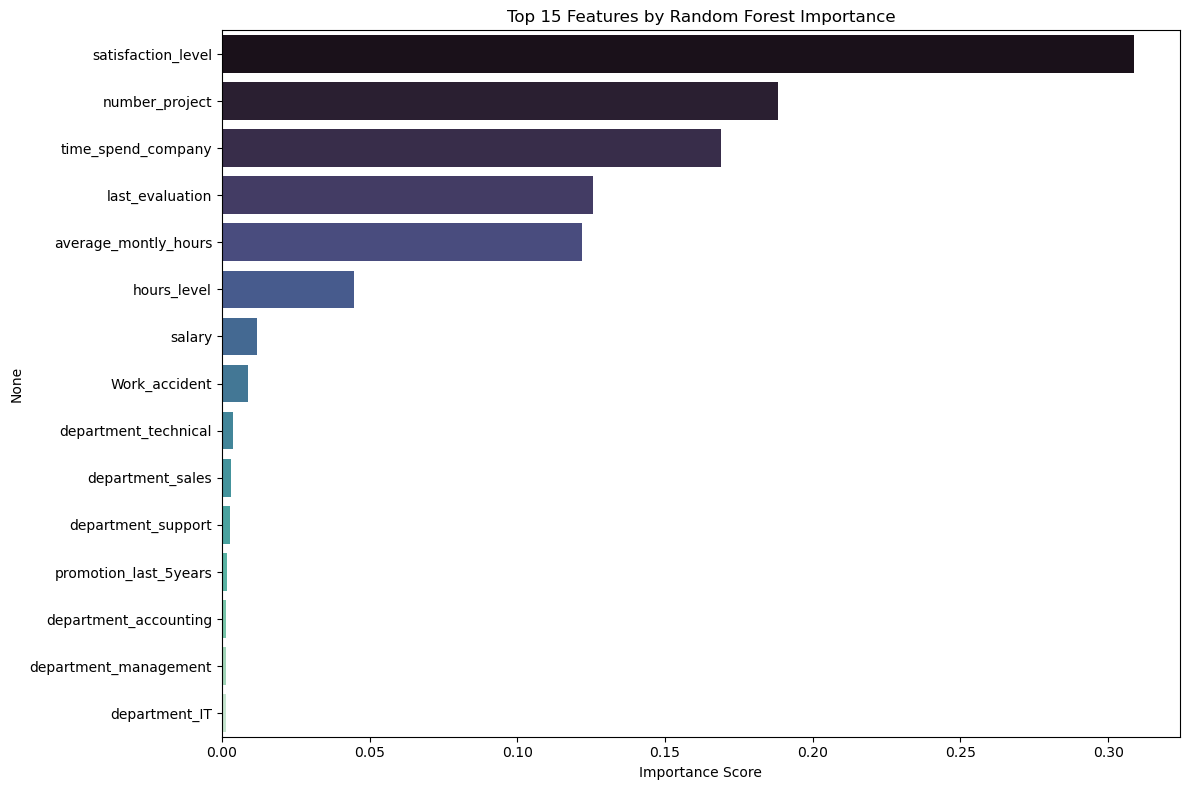

In [13]:
# 1.3 Tree-based Feature Importance
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
sorted_idx = importances.argsort()[::-1]

plt.figure(figsize=(12, 8))
sns.barplot(x=importances[sorted_idx][:15], y=X.columns[sorted_idx][:15], palette='mako')
plt.title('Top 15 Features by Random Forest Importance')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300)
plt.show()

In [15]:
# Step 2: Create new features
# ------------------------------------------------------------

# 2.1 Satisfaction-Evaluation interaction
df['satisfaction_eval_interaction'] = df['satisfaction_level'] * df['last_evaluation']

# 2.2 Overworked indicator
df['overworked'] = (df['average_montly_hours'] > 250).astype(int)

# 2.3 Workload per project
df['workload_per_project'] = df['average_montly_hours'] / (df['number_project'] + 1e-5)

# 2.4 Performance-satisfaction ratio
df['performance_satisfaction_ratio'] = df['last_evaluation'] / (df['satisfaction_level'] + 1e-5)


In [17]:
# Step 3: Remove low-importance and highly correlated features
# ------------------------------------------------------------

# 3.1 Identify highly correlated features
corr_matrix = df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
high_corr = [column for column in upper.columns if any(upper[column] > 0.85)]

# 3.2 Identify low-importance features (importance < 0.01)
low_importance = [col for col, imp in zip(X.columns, importances) if imp < 0.01]

# 3.3 Drop identified features
features_to_drop = list(set(high_corr + low_importance))
print(f"Features to drop: {features_to_drop}")
df_clean = df.drop(features_to_drop, axis=1, errors='ignore')

Features to drop: ['department_RandD', 'department_marketing', 'department_sales', 'department_management', 'hours_level', 'satisfaction_eval_interaction', 'department_accounting', 'department_product_mng', 'promotion_last_5years', 'department_support', 'department_technical', 'Work_accident', 'department_IT', 'department_hr']


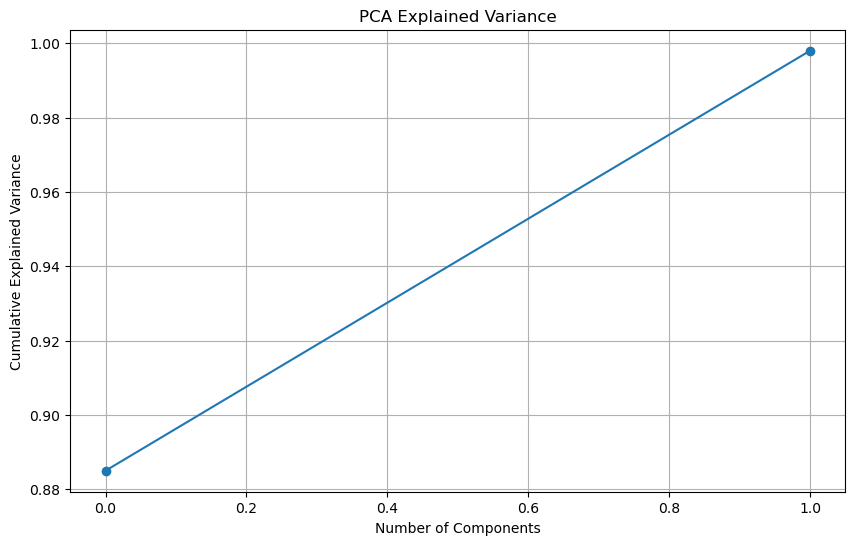

Original features: 9
Features after PCA: 2


In [19]:
# Step 4: Apply dimensionality reduction (PCA)
# ------------------------------------------------------------

# 4.1 Prepare data for PCA
X_clean = df_clean.drop('quit', axis=1)
y = df_clean['quit']

# 4.2 Apply PCA
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_clean)

# 4.3 Visualize PCA variance
plt.figure(figsize=(10, 6))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('PCA Explained Variance')
plt.grid(True)
plt.savefig('pca_variance.png', dpi=300)
plt.show()

print(f"Original features: {X_clean.shape[1]}")
print(f"Features after PCA: {pca.n_components_}")

In [21]:
# Step 5: Evaluate model improvements
# ------------------------------------------------------------

# 5.1 Split data
X_train_orig, X_test_orig, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_clean, X_test_clean, _, _ = train_test_split(X_clean, y, test_size=0.2, random_state=42)
X_train_pca, X_test_pca, _, _ = train_test_split(X_pca, y, test_size=0.2, random_state=42)

In [23]:
# 5.2 Train and evaluate models
results = {}

# Baseline model (original features)
rf_orig = RandomForestClassifier(random_state=42)
rf_orig.fit(X_train_orig, y_train)
orig_acc = accuracy_score(y_test, rf_orig.predict(X_test_orig))
results['Original Features'] = orig_acc

# Model with enhanced features
rf_clean = RandomForestClassifier(random_state=42)
rf_clean.fit(X_train_clean, y_train)
clean_acc = accuracy_score(y_test, rf_clean.predict(X_test_clean))
results['Enhanced Features'] = clean_acc

# Model with PCA
rf_pca = RandomForestClassifier(random_state=42)
rf_pca.fit(X_train_pca, y_train)
pca_acc = accuracy_score(y_test, rf_pca.predict(X_test_pca))
results['PCA Features'] = pca_acc

C:\Users\SMAGDY\AppData\Local\Temp\ipykernel_13832\2234696096.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(results.values()), y=list(results.keys()), palette='viridis')


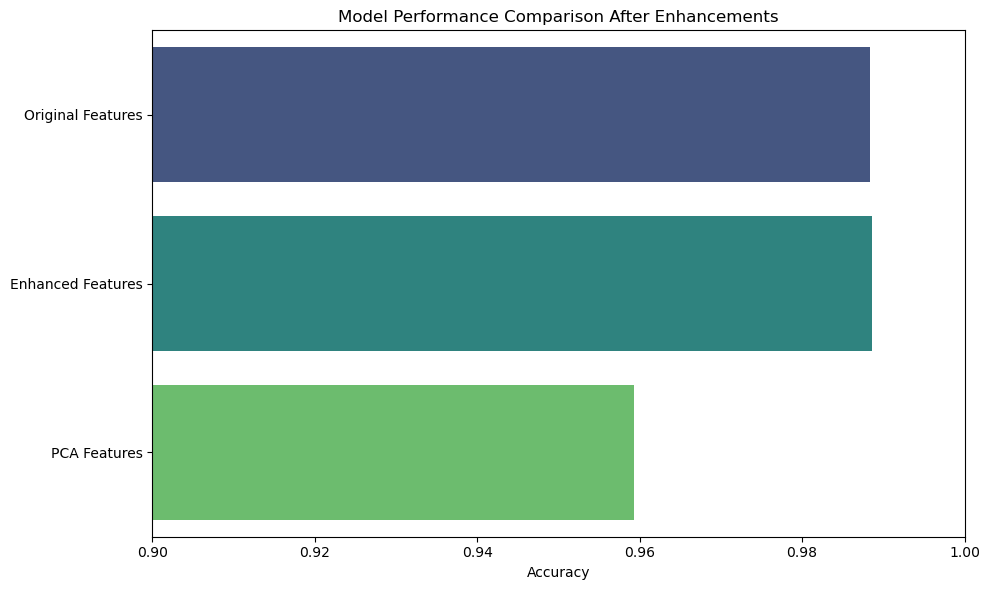


Performance Comparison:
Original Features: 0.9883
Enhanced Features: 0.9887
PCA Features: 0.9593


In [25]:
# 5.3 Compare results
plt.figure(figsize=(10, 6))
sns.barplot(x=list(results.values()), y=list(results.keys()), palette='viridis')
plt.title('Model Performance Comparison After Enhancements')
plt.xlabel('Accuracy')
plt.xlim(0.9, 1.0)
plt.tight_layout()
plt.savefig('model_performance_comparison.png', dpi=300)
plt.show()

print("\nPerformance Comparison:")
for model, acc in results.items():
    print(f"{model}: {acc:.4f}")

In [27]:
# 5.4 Top features after enhancement
importances_clean = rf_clean.feature_importances_
sorted_idx_clean = importances_clean.argsort()[::-1]
top_features = X_clean.columns[sorted_idx_clean][:10]

print("\nTop Features After Enhancement:")
print(top_features.tolist())


Top Features After Enhancement:
['satisfaction_level', 'performance_satisfaction_ratio', 'time_spend_company', 'number_project', 'average_montly_hours', 'last_evaluation', 'workload_per_project', 'salary', 'overworked']
